# **Bias measuring and mitigation in recommendation systems**

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "recommendation systems" one of them. A recommender system aims to recommend the best item according to the user preference.

There are various techniques to measure bias in recommendation systems. One common approach is to use fairness metrics such as aggregate diversity, exposure entropy, or gini index, which are item based metrics that, in general terms, calculate the distribution to observe the proportions of items are shown to the user.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

A recommender system can be biased in multiple ways. For example, we may be concerned that the artists in our database will not get equal representation (item fairness). Alternative, our main concern may be that different groups of users (e.g. male/female users) will get different music recommendations (user fairness). In the following, we will show how to explore the data for fairness, and measure these various types of fairness using the holisticai library.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in recommender systems, specially by using a synthetic dataset that generates rankings of candidates using the Yang-Stoyanovich process.

We will follow the traditional outline for this tutorial:

1. Data loading and packages installation
2. Data exploration
3. Bias mitigation
4. Results comparison

## **1. Data loading and packages installation**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai
```

In [1]:
# Base Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

The dataset that we will use is a synthetic ranking dataset generated following the procedure described by Yang and Stoyanovich in their [research](https://arxiv.org/abs/1610.08559). This algorithm creates a ranked output of protected and unprotected candidates with a certain probability.

To do that we will use the `generate_rankings` function that takes as arguments the number of `k` elements that will be generated for all the `M` lists under a probability `p` to be protected. 

For our case we will generate only one ranked list of 20 elements.

In [3]:
from holisticai.datasets.synthetic.recruitment import generate_rankings

In [4]:
M = 1
k = 20
p = 0.1
ranking = generate_rankings(M, k, p)
ranking.head()

,X,Y,score,protected
0,0,20,20,False
1,0,19,19,True
2,0,18,18,False
3,0,17,17,False
4,0,16,16,False


To add bias into the dataset we will modify the `protected` column where the protected elements will be only the last six elements.

In [5]:
def create_unfair_example(ranking, n):
    """
    Setting an unfair ranking where protected group examples are only the last n results.
    """
    ranking = ranking.copy()
    ranking['protected']=False
    ranking['protected'].iloc[-n:]=True
    return ranking
    
unfair_ranking = create_unfair_example(ranking, 6)

In [5]:
unfair_ranking

,X,Y,score,protected
0,0,20,20,False
1,0,19,19,False
2,0,18,18,False
3,0,17,17,False
4,0,16,16,False
5,0,15,15,False
6,0,14,14,False
7,0,13,13,False
8,0,12,12,False
9,0,11,11,False


From now on, we are going to assume that both rankings are outputs from a recommender system, and we will analyze the bias in the recommendations. Therefore, our purpose will be to measure and then  mitigate the bias in the recommendations.

## **2. Data exploration**

In [6]:
unfair_ranking.describe()

,X,Y,score
count,20.0,20.00000,20.00000
mean,0.0,10.50000,10.50000
std,0.0,5.91608,5.91608
min,0.0,1.00000,1.00000
25%,0.0,5.75000,5.75000
50%,0.0,10.50000,10.50000
75%,0.0,15.25000,15.25000
max,0.0,20.00000,20.00000


<Axes: title={'center': 'Group proportions'}>

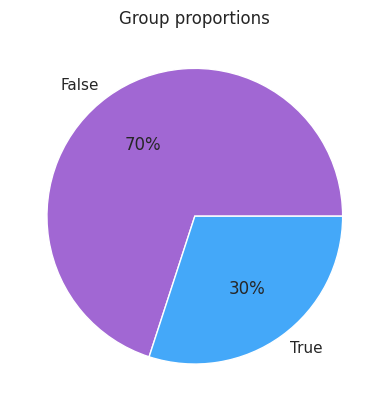

In [7]:
from holisticai.bias.plots import group_pie_plot, frequency_plot

group_pie_plot(unfair_ranking['protected'])

This graph show us that the proportion of the unprotected group is very high compared to the protected examples.


## **3. Bias mitigation**

### **Post-processing: Fair Top-K method**

Now that we have a highly biased dataset, we need to apply some kind of strategy to mitigate the bias present.

Exists different kinds of strategies, and the literature has divided them into three categories: "Pre-processing", "in-processing" and "post-processing" methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library.

For this opportunity, we will implement the "Fair Top-K" method which is a post-processing algorithm that extends group fairness definition using the standard notion of protected groups mitigating biases in the representation of the under-represented group along a ranked list.

In [8]:
from holisticai.bias.mitigation.postprocessing.fair_topk.transformer import FairTopK

In [9]:
# Bias Mitigation Post-processing
top_n = 20
p = 0.9
alpha = 0.15
fs = FairTopK(top_n=top_n, 
              p=p, 
              alpha=alpha, 
              query_col='X', 
              doc_col='Y', 
              score_col='score', 
              group_col='protected')


In [10]:
re_ranking = fs.transform(unfair_ranking)

## **4. Results comparison**

Now that we could observe how is the implementation of the mitigator, we will compare the results between the baseline and the implementation with the mitigator to analyse how the ranked list has changed.

In [11]:
def compare_results(old , new):
    old = old.copy()
    new = new.copy()
    old.columns = pd.MultiIndex.from_tuples([['Old Rank',col] for col in old.columns])
    new.columns = pd.MultiIndex.from_tuples([['New Rank',col] for col in new.columns])
    return pd.concat([old.reset_index(drop=True),new.reset_index(drop=True)], axis=1)

In [12]:
compare_results(unfair_ranking , re_ranking)

Old Rank                     New Rank                    
          X   Y score protected        X   Y score protected
0         0  20    20     False        0  20    20     False
1         0  19    19     False        0   6     6      True
2         0  18    18     False        0   5     5      True
3         0  17    17     False        0   4     4      True
4         0  16    16     False        0   3     3      True
5         0  15    15     False        0  19    19     False
6         0  14    14     False        0   2     2      True
7         0  13    13     False        0   1     1      True
8         0  12    12     False        0  18    18     False
9         0  11    11     False        0  17    17     False
10        0  10    10     False        0  16    16     False
11        0   9     9     False        0  15    15     False
12        0   8     8     False        0  14    14     False
13        0   7     7     False        0  13    13     False
14        0   6     6      True        0  12    12     False
15        0   5     5      True        0  11    11     False
16        0   4     4      True        0  10    10     False
17        0   3     3      True        0   9     9     False
18        0   2     2      True        0   8     8     False
19        0   1     1      True        0   7     7     False

As we can see, the under-represented group has gained attention in the top part of the ranked list. This is achieved because the method uses statistical tests to mitigate the bias present in the data. 

# **Summary**

Through this tutorial we could present to the user how to mitigate the bias present in a ranked list by applying the "Fair Top-k" technique to reorganize the given list, this is a post-processing method that ensures the presence of protected candidates in the top part of the list. Consequently we could observe how this modification can be done easily.